In [1]:
# Install necessary packages
!pip install accelerate -U
!pip install datasets transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Dataset link: https://huggingface.co/datasets/osanseviero/twitter-airline-sentiment/blob/main/Tweets.csv

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Mount Google Drive to access dataset
drive.mount('/content/drive')

# Load dataset
dataset = pd.read_csv('/content/drive/MyDrive/Tweets.csv')

Mounted at /content/drive


**Exploratory Data Analysis:** Dataset is visualised to understand the insight of data and to perform meaningful pre-processing

In [4]:
# ---------------------------------------------------------
# Exploratory Data Analysis (EDA)
# ---------------------------------------------------------

# Data Overview
print("The shape of the dataset is:", dataset.shape)
print("Number of sentiments in each category:\n", dataset['airline_sentiment'].value_counts())



The shape of the dataset is: (14640, 15)
Number of sentiments in each category:
 airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


<ipython-input-5-15ba19094a38>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='airline_sentiment', palette='Set2')


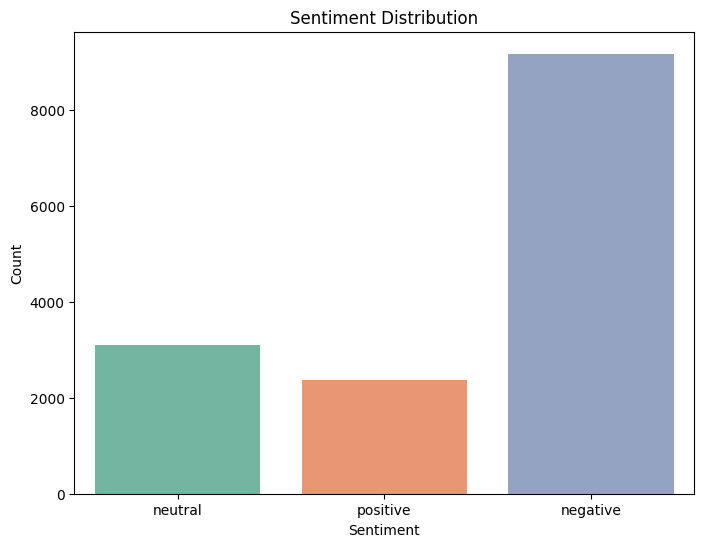

In [5]:
# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=dataset, x='airline_sentiment', palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


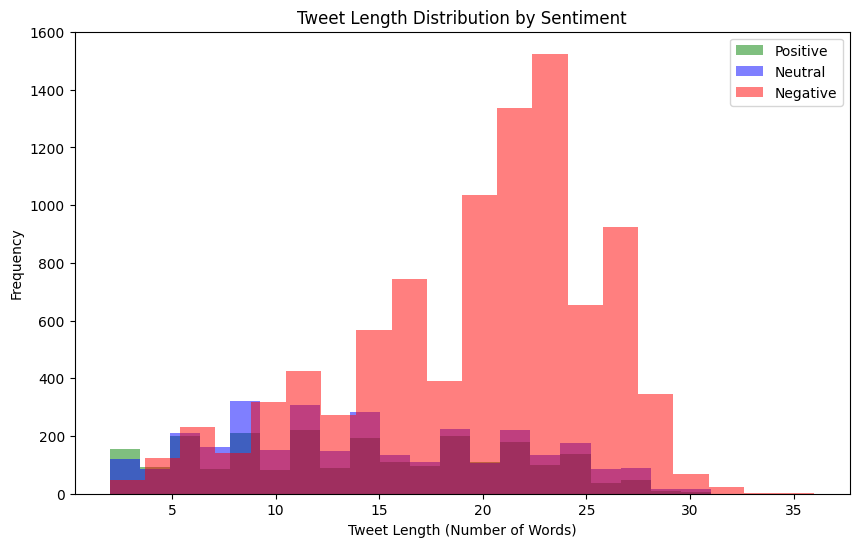

In [14]:
# Calculate tweet lengths for each sentiment category
positive_tweets = dataset[dataset['airline_sentiment'] == 'positive']['text']
neutral_tweets = dataset[dataset['airline_sentiment'] == 'neutral']['text']
negative_tweets = dataset[dataset['airline_sentiment'] == 'negative']['text']

positive_tweet_lengths = positive_tweets.apply(lambda x: len(x.split()))
neutral_tweet_lengths = neutral_tweets.apply(lambda x: len(x.split()))
negative_tweet_lengths = negative_tweets.apply(lambda x: len(x.split()))

# Plot histograms for tweet length distribution
plt.figure(figsize=(10, 6))
plt.hist(positive_tweet_lengths, bins=20, color='green', alpha=0.5, label='Positive')
plt.hist(neutral_tweet_lengths, bins=20, color='blue', alpha=0.5, label='Neutral')
plt.hist(negative_tweet_lengths, bins=20, color='red', alpha=0.5, label='Negative')
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Tweet Length (Number of Words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


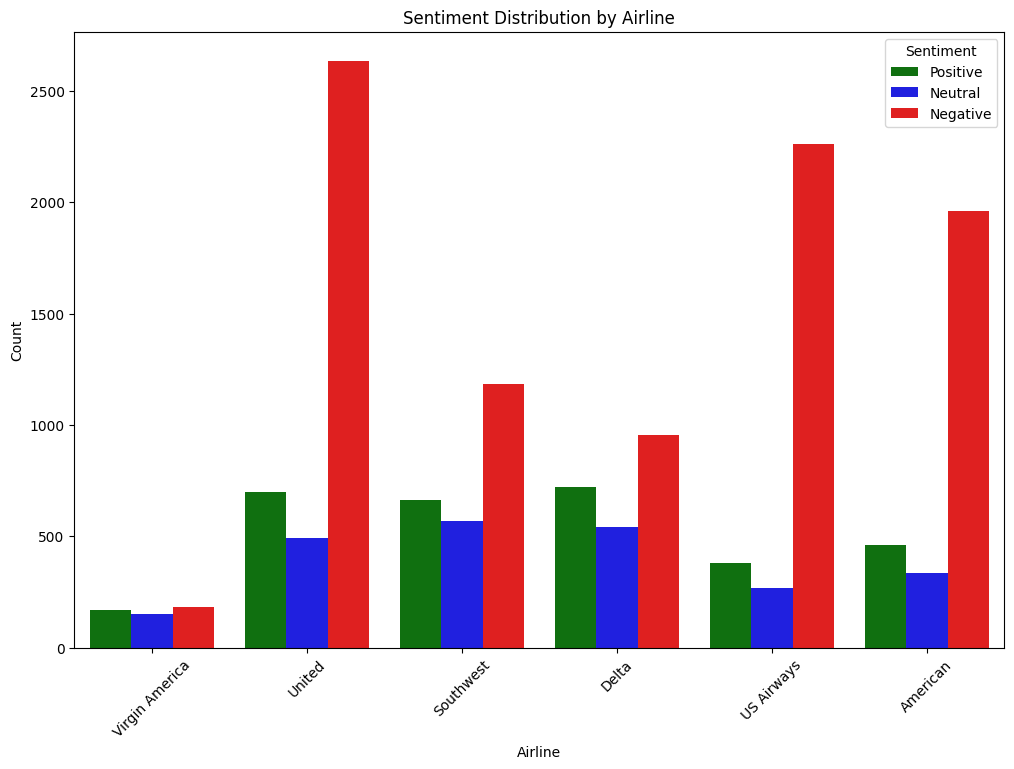

In [7]:
# Sentiment Distribution by Airline
plt.figure(figsize=(12, 8))
sns.countplot(data=dataset, x='airline', hue='airline_sentiment', palette=['green', 'blue', 'red'])
plt.title('Sentiment Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', labels=['Positive', 'Neutral', 'Negative'])
plt.show()

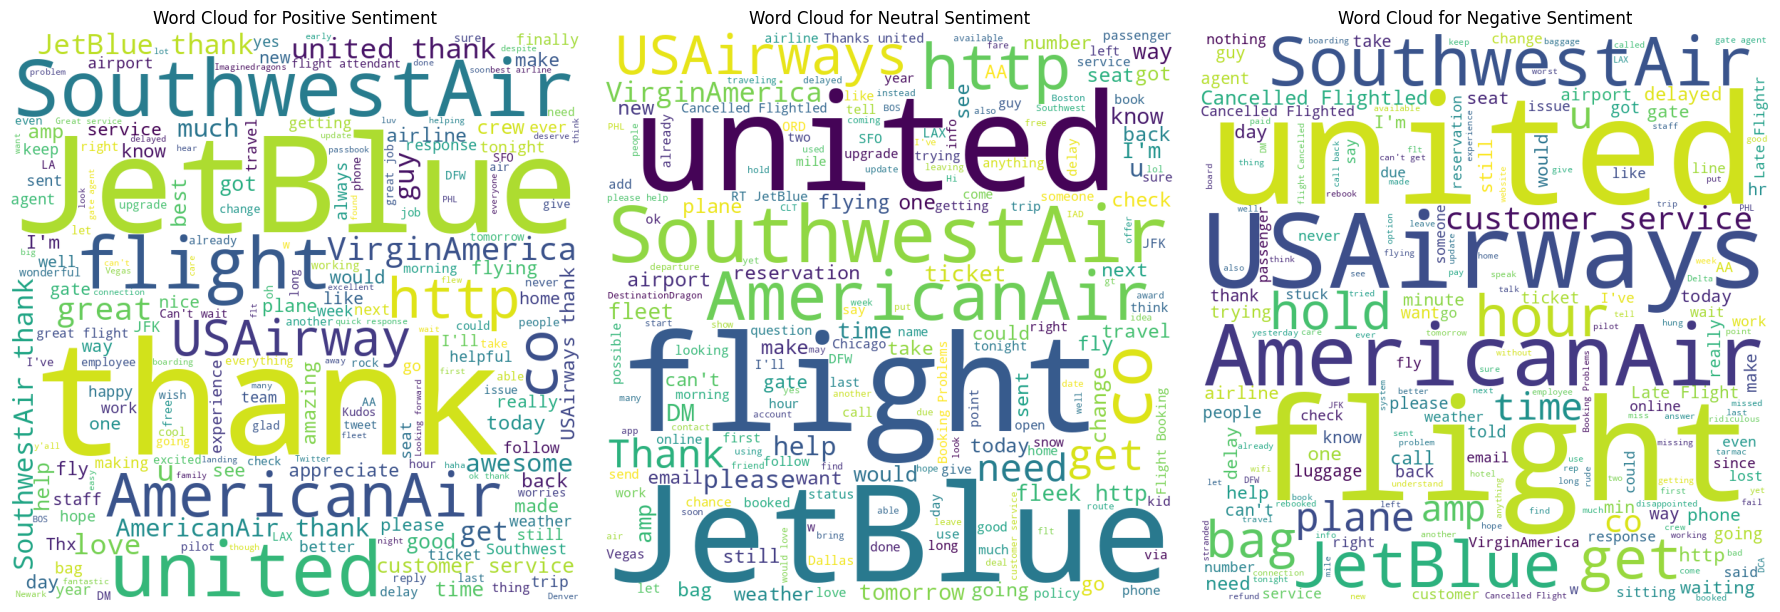

In [12]:
# Generate Word Clouds for each sentiment category
stopwords = set(stopwords.words('english'))
positive_tweets = dataset[dataset['airline_sentiment'] == 'positive']['text']
neutral_tweets = dataset[dataset['airline_sentiment'] == 'neutral']['text']
negative_tweets = dataset[dataset['airline_sentiment'] == 'negative']['text']

wordcloud_positive = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(' '.join(positive_tweets))
wordcloud_neutral = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(' '.join(neutral_tweets))
wordcloud_negative = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(' '.join(negative_tweets))

# Plot Word Clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, wc, title in zip(axes.flatten(), [wordcloud_positive, wordcloud_neutral, wordcloud_negative], ['Positive', 'Neutral', 'Negative']):
    ax.imshow(wc)
    ax.set_title(f'Word Cloud for {title} Sentiment')
    ax.axis('off')
plt.tight_layout()
plt.show()


**Data Pre-processing:** Dataset mapping ,also known as one-hot encoding of target categorical variable ino values which could be further fed to the model

In [15]:
# ---------------------------------------------------------
# Data Preprocessing
# ---------------------------------------------------------

# Map sentiment labels to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': 2}
dataset['airline_sentiment'] = dataset['airline_sentiment'].map(sentiment_mapping)

# Split dataset into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Train set shape: (11712, 15)
Test set shape: (2928, 15)


**Model training Steps:**

In [19]:
class AirlineReviewsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 256

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        labels = self.data.iloc[index][['airline_sentiment']].values.astype(int)
        encoding = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        # resize the tensors to the same size
        input_ids = nn.functional.pad(input_ids, (0, self.max_length - input_ids.shape[0]), value=0)
        attention_mask = nn.functional.pad(attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0)
        return input_ids, attention_mask, torch.tensor(labels)

In [20]:
model_checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = AirlineReviewsDataset(train_data, tokenizer)
test_dataset = AirlineReviewsDataset(test_data, tokenizer)

In [21]:
#args

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_checkpoint)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)

        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state'][:, 0, :]
        x = self.classifier(x)
        return x

In [23]:
num_labels = 3
model = BertClassifier(num_labels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)

num_epochs = 3
n_total_steps = len(train_loader)

In [24]:
# Initialize an empty list to store the loss values
loss_values = []

for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.view(-1).to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Append the loss value to the list
        loss_values.append(loss.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/3], Step [100/366], Loss: 0.7214
Epoch [1/3], Step [200/366], Loss: 0.5560
Epoch [1/3], Step [300/366], Loss: 0.5740
Epoch [2/3], Step [100/366], Loss: 0.3666
Epoch [2/3], Step [200/366], Loss: 0.3620
Epoch [2/3], Step [300/366], Loss: 0.3941
Epoch [3/3], Step [100/366], Loss: 0.0549
Epoch [3/3], Step [200/366], Loss: 0.3539
Epoch [3/3], Step [300/366], Loss: 0.1219


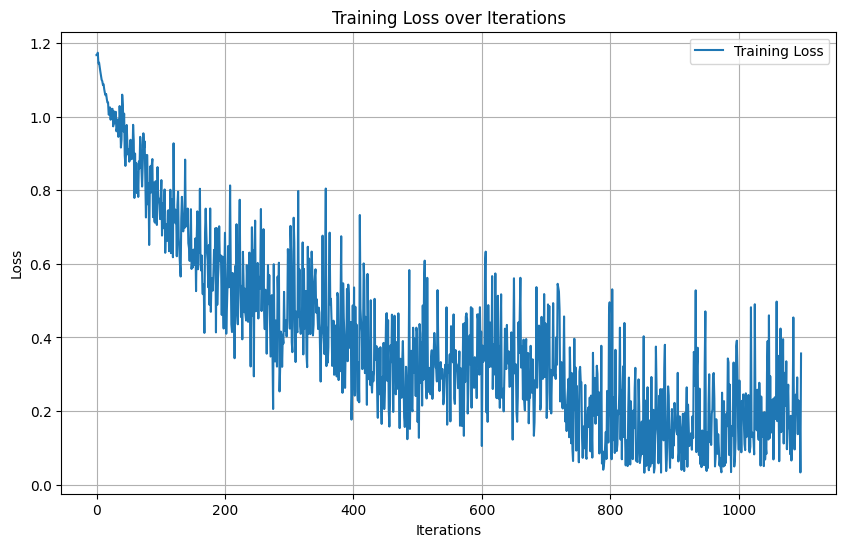

In [25]:


# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()

**MOdel evaluation and prediction on Test set**

In [26]:
all_labels = []
all_preds = []

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for i, batch in enumerate (test_loader):

    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)

    attention_mask = attention_mask.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    outputs = model(input_ids, attention_mask)

    _, predictions = torch.max(outputs, 1)

    all_labels.append(labels.cpu().numpy())
    all_preds.append(predictions.cpu().numpy())

all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       580
           1       0.71      0.85      0.77       459
           2       0.93      0.89      0.91      1889

    accuracy                           0.84      2928
   macro avg       0.78      0.81      0.79      2928
weighted avg       0.85      0.84      0.84      2928

0.8418715846994536


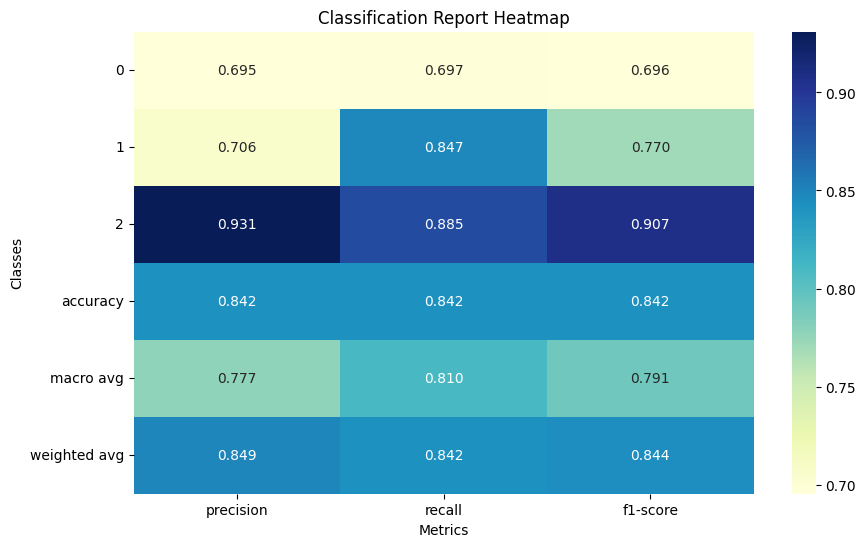

In [29]:


# Classification report
report = classification_report(all_labels, all_preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.drop(['support'], axis=1), annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()

In [27]:
# Print classification report and accuracy score
print("Classification Report:")
print(classification_report(all_labels, all_preds))
print("\nAccuracy Score:", accuracy_score(all_labels, all_preds))

# Check specific sentiments
sentiments_to_check = ['positive', 'neutral', 'negative']
for sentiment in sentiments_to_check:
    sentiment_index = sentiment_mapping[sentiment]
    indices = np.where(all_labels == sentiment_index)[0]
    print(f"\nChecking {sentiment} sentiments:")
    for idx in indices[:5]:  # Printing predictions for the first 5 instances of each sentiment
        text = test_data.iloc[idx]['text']
        predicted_sentiment = list(sentiment_mapping.keys())[all_preds[idx]]
        print(f"Text: {text}")
        print(f"Predicted Sentiment: {predicted_sentiment}\n")


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       580
           1       0.71      0.85      0.77       459
           2       0.93      0.89      0.91      1889

    accuracy                           0.84      2928
   macro avg       0.78      0.81      0.79      2928
weighted avg       0.85      0.84      0.84      2928


Accuracy Score: 0.8418715846994536

Checking positive sentiments:
Text: @SouthwestAir you're my early frontrunner for best airline! #oscars2016
Predicted Sentiment: neutral

Text: @usairways great crew for flight 504 PHX to YVR tonight! Friendly, efficient. Awesome job.
Predicted Sentiment: neutral

Text: @SouthwestAir Already signed up!  Thanks!  Looking forward to trying the Southwest experience.
Predicted Sentiment: neutral

Text: @USAirways Oh well. I'll get to Cancun eventually.
Predicted Sentiment: neutral

Text: @SouthwestAir thanks for the quick response. Should I call daily it wa